# Analisar dados em um data warehouse Relacional

## Tabelas de dimensões

As tabelas de dimensões descrevem entidades de negócios, como produtos, pessoas, locais e datas. As tabelas de dimensões contêm colunas para os atributos de uma entidade. Por exemplo, uma entidade de cliente pode ter um nome, um sobrenome, um endereço de email e um endereço postal (que pode ser composto por um endereço, uma cidade, um código postal e um país ou uma região). Além das colunas de atributos, uma tabela de dimensões contém uma coluna de chave exclusiva que identifica exclusivamente cada linha na tabela. Na verdade, é comum que uma tabela de dimensões inclua duas colunas de chave:

uma chave substitutiva que é específica do data warehouse e identifica exclusivamente cada linha na tabela de dimensões no data warehouse – geralmente um número inteiro que aumenta progressivamente.

Uma chave alternativa , geralmente uma chave natural ou comercial que é usada para identificar uma instância específica de uma entidade no sistema de origem transacional do qual o registro de entidade se originou , como um código do produto ou uma ID do cliente.

## Tabela de fatos

Tabelas de fatos armazenam detalhes de observações ou eventos; por exemplo, ordens de vendas, saldos de ações, taxas de câmbio ou leituras de temperatura. Uma tabela de fatos contém colunas para valores numéricos que podem ser agregados por dimensões. Além das colunas numéricas, uma tabela de fatos contém colunas de chave que fazem referência a chaves exclusivas em tabelas de dimensões relacionadas.

## Designs de esquema de data warehouse

Na maioria dos bancos de dados transacionais usados em aplicativos de negócios, os dados são normalizados para reduzir a duplicação. Em um data warehouse, no entanto, os dados de dimensão geralmente são des normalizados para reduzir o número de junções necessárias para consultar os dados.

Geralmente, um data warehouse é organizado como um esquema de estrela , no qual uma tabela de fatos está diretamente relacionada às tabelas de dimensão

Os atributos de uma entidade podem ser usados para agregar medidas em tabelas de fatos em vários níveis hierárquicos – por exemplo, para localizar a receita total de vendas por país ou região, cidade, código postal ou cliente individual. Os atributos de cada nível podem ser armazenados na mesma tabela de dimensões. No entanto, quando uma entidade tem um grande número de níveis de atributo hierárquico ou quando alguns atributos podem ser compartilhados por várias dimensões (por exemplo, clientes e lojas têm um endereço geográfico), pode fazer sentido aplicar alguma normalização às tabelas de dimensão e criar um esquema floco de neve

## Criando um pool de SQL dedicado

Para criar um data warehouse relacional no Azure Synapse Analytics, você deve criar um Pool de SQL dedicado.

mais simples de fazer isso em um workspace existente do Azure Synapse Analytics é usar a página Gerenciar no Azure Synapse Studio, conforme mostrado aqui:

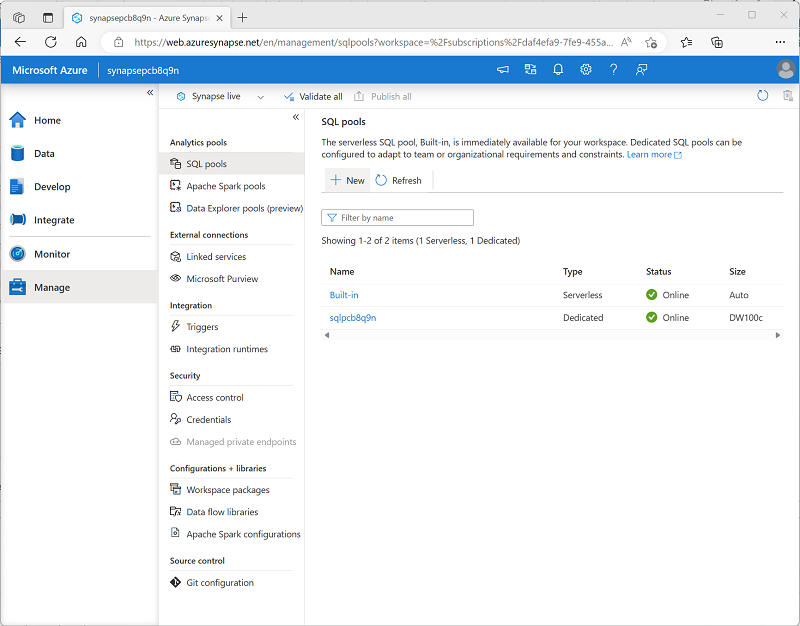

Ao provisionar um pool de SQL dedicado, você pode especificar as seguintes configurações:

Um nome exclusivo para o pool de SQL dedicado.

Um nível de desempenho para o pool de SQL, que pode variar de DW100c a DW30000c e que determina o custo por hora para o pool quando ele está em execução.

Seja para começar com um pool vazio ou restaurar um banco de dados existente de um backup.

A ordenação do pool de SQL, que determina a ordem de classificação e as regras de comparação de cadeia de caracteres para o banco de dados.

Depois de criar um pool de SQL dedicado, você pode controlar seu estado de execução na página Gerenciar do Synapse Studio; pausando-o quando não necessário para evitar custos desnecessários.

Quando o pool estiver em execução, você poderá explorá-lo na página Dados e criar scripts SQL para serem executados nele.

## Criando tabelas de dimensão

Ao criar uma tabela de dimensão, verifique se a definição da tabela inclui chaves substitutas e alternativas, bem como colunas para os atributos da dimensão que você deseja usar para agrupar agregações. Geralmente, é mais fácil usar uma IDENTITY coluna para gerar automaticamente uma chave substituta de incremento:

In [ ]:
CREATE TABLE dbo.DimCustomer
(
    CustomerKey INT IDENTITY NOT NULL,
    CustomerAlternateKey NVARCHAR(15) NULL,
    CustomerName NVARCHAR(80) NOT NULL,
    EmailAddress NVARCHAR(50) NULL,
    Phone NVARCHAR(25) NULL,
    StreetAddress NVARCHAR(100),
    City NVARCHAR(20),
    PostalCode NVARCHAR(10),
    CountryRegion NVARCHAR(20)
)
WITH
(
    DISTRIBUTION = REPLICATE,
    CLUSTERED COLUMNSTORE INDEX
);

Se você pretende usar um esquema floco de neve no qual as tabelas de dimensão estão relacionadas umas às outras, você deve incluir a chave para a dimensão pai na definição da tabela de dimensão filho. Por exemplo, o código SQL a seguir pode ser usado para mover os detalhes do endereço geográfico da tabela DimCustomer para uma tabela de dimensão DimGeography separada:

In [ ]:
CREATE TABLE dbo.DimGeography
(
    GeographyKey INT IDENTITY NOT NULL,
    GeographyAlternateKey NVARCHAR(10) NULL,
    StreetAddress NVARCHAR(100),
    City NVARCHAR(20),
    PostalCode NVARCHAR(10),
    CountryRegion NVARCHAR(20)
)
WITH
(
    DISTRIBUTION = REPLICATE,
    CLUSTERED COLUMNSTORE INDEX
);

CREATE TABLE dbo.DimCustomer
(
    CustomerKey INT IDENTITY NOT NULL,
    CustomerAlternateKey NVARCHAR(15) NULL,
    GeographyKey INT NULL,
    CustomerName NVARCHAR(80) NOT NULL,
    EmailAddress NVARCHAR(50) NULL,
    Phone NVARCHAR(25) NULL
)
WITH
(
    DISTRIBUTION = REPLICATE,
    CLUSTERED COLUMNSTORE INDEX
);

## Tabelas de dimensão de tempo

A maioria dos data warehouses inclui uma tabela de dimensão de tempo que permite agregar dados por vários níveis hierárquicos de intervalo de tempo. Por exemplo, o exemplo a seguir cria uma tabela DimDate com atributos relacionados a datas específicas.

In [ ]:
CREATE TABLE dbo.DimDate
(
    DateKey INT NOT NULL,
    DateAltKey DATETIME NOT NULL,
    DayOfMonth INT NOT NULL,
    DayOfWeek INT NOT NULL,
    DayName NVARCHAR(15) NOT NULL,
    MonthOfYear INT NOT NULL,
    MonthName NVARCHAR(15) NOT NULL,
    CalendarQuarter INT  NOT NULL,
    CalendarYear INT NOT NULL,
    FiscalQuarter INT NOT NULL,
    FiscalYear INT NOT NULL
)
WITH
(
    DISTRIBUTION = REPLICATE,
    CLUSTERED COLUMNSTORE INDEX
);

## Criando tabelas de fatos

As tabelas de fatos incluem as chaves de cada dimensão à qual estão relacionadas e os atributos e medidas numéricas para eventos ou observações específicos que você deseja analisar.

O exemplo de código a seguir cria uma tabela de fatos hipotética chamada FactSales que está relacionada a várias dimensões por meio de colunas de chave (data, cliente, produto e repositório)

In [ ]:
CREATE TABLE dbo.FactSales
(
    OrderDateKey INT NOT NULL,
    CustomerKey INT NOT NULL,
    ProductKey INT NOT NULL,
    StoreKey INT NOT NULL,
    OrderNumber NVARCHAR(10) NOT NULL,
    OrderLineItem INT NOT NULL,
    OrderQuantity SMALLINT NOT NULL,
    UnitPrice DECIMAL NOT NULL,
    Discount DECIMAL NOT NULL,
    Tax DECIMAL NOT NULL,
    SalesAmount DECIMAL NOT NULL
)
WITH
(
    DISTRIBUTION = HASH(OrderNumber),
    CLUSTERED COLUMNSTORE INDEX
);

## Criando tabelas de preparo

As tabelas de preparo são usadas como armazenamento temporário para os dados enquanto eles são carregadas no data warehouse. Um padrão típico é estruturar a tabela para torná-la o mais eficiente possível para ingerir os dados de sua fonte externa (geralmente arquivos em um data lake) no banco de dados relacional e, em seguida, usar instruções SQL para carregar os dados das tabelas de preparo nas tabelas de dimensão e fatos.

O seguinte exemplo de código cria uma tabela de preparo para dados do produto que, em última análise, serão carregados em uma tabela de dimensões:

In [ ]:
CREATE TABLE dbo.StageProduct
(
    ProductID NVARCHAR(10) NOT NULL,
    ProductName NVARCHAR(200) NOT NULL,
    ProductCategory NVARCHAR(200) NOT NULL,
    Color NVARCHAR(10),
    Size NVARCHAR(10),
    ListPrice DECIMAL NOT NULL,
    Discontinued BIT NOT NULL
)
WITH
(
    DISTRIBUTION = ROUND_ROBIN,
    CLUSTERED COLUMNSTORE INDEX
);

## Usando tabelas externas

Em alguns casos, se os dados a serem carregados estiverem em arquivos com uma estrutura apropriada, poderá ser mais eficaz criar tabelas externas que referenciam o local do arquivo.

O exemplo a seguir mostra como criar uma tabela externa que referencia arquivos no data lake associado ao workspace do Synapse:

In [ ]:
-- External data source links to data lake location
CREATE EXTERNAL DATA SOURCE StagedFiles
WITH (
    LOCATION = 'https://mydatalake.blob.core.windows.net/data/stagedfiles/'
);
GO

-- External format specifies file format
CREATE EXTERNAL FILE FORMAT ParquetFormat
WITH (
    FORMAT_TYPE = PARQUET,
    DATA_COMPRESSION = 'org.apache.hadoop.io.compress.SnappyCodec'
);
GO

-- External table references files in external data source
CREATE EXTERNAL TABLE dbo.ExternalStageProduct
(
    ProductID NVARCHAR(10) NOT NULL,
    ProductName NVARCHAR(200) NOT NULL,
    ProductCategory NVARCHAR(200) NOT NULL,
    Color NVARCHAR(10),
    Size NVARCHAR(10),
    ListPrice DECIMAL NOT NULL,
    Discontinued BIT NOT NULL
)
WITH
(
    DATA_SOURCE = StagedFiles,
    LOCATION = 'products/*.parquet',
    FILE_FORMAT = ParquetFormat
);
GO

## Consultar um armazém de dados

Por exemplo, o SQL a seguir consulta as tabelas FactSales e DimDate em um data warehouse hipotético para agregar valores de vendas por ano e trimestre:

In [ ]:
SELECT  dates.CalendarYear,
        dates.CalendarQuarter,
        SUM(sales.SalesAmount) AS TotalSales
FROM dbo.FactSales AS sales
JOIN dbo.DimDate AS dates ON sales.OrderDateKey = dates.DateKey
GROUP BY dates.CalendarYear, dates.CalendarQuarter
ORDER BY dates.CalendarYear, dates.CalendarQuarter;

Você pode unir quantas tabelas de dimensões forem necessárias para calcular as agregações de que precisa. Por exemplo, o código a seguir estende o exemplo anterior para dividir os totais de vendas trimestrais por cidade com base nos detalhes do endereço do cliente na tabela DimCustomer :

In [ ]:
SELECT  dates.CalendarYear,
        dates.CalendarQuarter,
        custs.City,
        SUM(sales.SalesAmount) AS TotalSales
FROM dbo.FactSales AS sales
JOIN dbo.DimDate AS dates ON sales.OrderDateKey = dates.DateKey
JOIN dbo.DimCustomer AS custs ON sales.CustomerKey = custs.CustomerKey
GROUP BY dates.CalendarYear, dates.CalendarQuarter, custs.City
ORDER BY dates.CalendarYear, dates.CalendarQuarter, custs.City;

Ao usar um esquema floco de neve, as dimensões podem estar parcialmente normalizadas, exigindo várias junções para relacionar tabelas de fatos a dimensões de floco de neve. Por exemplo, suponha que o data warehouse inclui uma tabela de dimensões DimProduct da qual as categorias de produto foram normalizadas em uma tabela DimCategory separada. Uma consulta para agregar itens vendidos por categoria de produto pode ser semelhante ao seguinte exemplo:

In [ ]:
SELECT  cat.ProductCategory,
        SUM(sales.OrderQuantity) AS ItemsSold
FROM dbo.FactSales AS sales
JOIN dbo.DimProduct AS prod ON sales.ProductKey = prod.ProductKey
JOIN dbo.DimCategory AS cat ON prod.CategoryKey = cat.CategoryKey
GROUP BY cat.ProductCategory
ORDER BY cat.ProductCategory;

Usando funções de classificação

ROW_NUMBER retorna a posição ordinal da linha dentro da partição. Por exemplo, a primeira linha é numerada como 1, a segunda como 2 e assim por diante.

RANK retorna a posição classificada de cada linha nos resultados ordenados. Por exemplo, em uma partição de lojas ordenadas pelo volume de vendas, a loja com o maior volume de vendas é classificada como 1. Se várias lojas tiverem os mesmos volumes de vendas, elas serão classificadas da mesma forma, e a classificação atribuída às lojas seguintes refletirá o número de lojas que têm volumes de vendas mais altos – incluindo empates.

DENSE_RANK classifica as linhas em uma partição da mesma forma que RANK, mas quando várias linhas têm a mesma classificação, as linhas seguintes nas posições de classificação ignoram empates.

NTILE retorna o percentil especificado em que a linha se enquadra. Por exemplo, em uma partição de lojas ordenadas pelo volume de vendas, NTILE(4) retorna o quartil em que o volume de vendas de uma loja a coloca.

In [ ]:
SELECT  ProductCategory,
        ProductName,
        ListPrice,
        ROW_NUMBER() OVER
            (PARTITION BY ProductCategory ORDER BY ListPrice DESC) AS RowNumber,
        RANK() OVER
            (PARTITION BY ProductCategory ORDER BY ListPrice DESC) AS Rank,
        DENSE_RANK() OVER
            (PARTITION BY ProductCategory ORDER BY ListPrice DESC) AS DenseRank,
        NTILE(4) OVER
            (PARTITION BY ProductCategory ORDER BY ListPrice DESC) AS Quartile
FROM dbo.DimProduct
ORDER BY ProductCategory;

Recuperando uma contagem aproximada

Embora a finalidade de um data warehouse seja principalmente dar suporte a modelos de dados analíticos e relatórios para a empresa, analistas e cientistas de dados geralmente precisam fazer alguma exploração inicial dos dados apenas para determinar a escala básica e a distribuição deles.

Por exemplo, a seguinte consulta usa a função COUNT para recuperar o número de vendas para cada ano em um data warehouse hipotético:

In [ ]:
SELECT dates.CalendarYear AS CalendarYear,
    COUNT(DISTINCT sales.OrderNumber) AS Orders
FROM FactSales AS sales
JOIN DimDate AS dates ON sales.OrderDateKey = dates.DateKey
GROUP BY dates.CalendarYear
ORDER BY CalendarYear;

# (Lab Pratico)Explorar um data warehouse

In [ ]:
 rm -r dp203 -f
 git clone  https://github.com/MicrosoftLearning/Dp-203-azure-data-engineer dp203

In [ ]:
 cd dp203/Allfiles/labs/08
 ./setup.ps1

## Explore o esquema do data warehouse

Na página Visão geral do seu espaço de trabalho Synapse, no cartão Abrir Synapse Studio, selecione Abrir para abrir o Synapse Studio

Na página Gerenciar, certifique-se de que a guia pools de SQL esteja selecionada e, em seguida, selecione o pool de SQL dedicado sqlxxxxxxx e use o ícone ▷ para iniciá-lo; confirmando que deseja retomá-lo quando solicitado.

Aguarde a retomada do pool de SQL. Isso pode levar alguns minutos. Use o botão ↻ Atualizar para verificar o status periodicamente. O status será exibido como Online quando estiver pronto.

## Consultar as tabelas do data warehouse

Consultar tabelas de fatos e dimensões

Na página Dados, selecione o pool de SQL sqlxxxxxxx e, no menu …, selecione Novo script SQL > Script vazio.

mostrar os totais de vendas na Internet de cada ano:

In [ ]:
 SELECT  d.CalendarYear AS Year,
         SUM(i.SalesAmount) AS InternetSalesAmount
 FROM FactInternetSales AS i
 JOIN DimDate AS d ON i.OrderDateKey = d.DateKey
 GROUP BY d.CalendarYear
 ORDER BY Year;

Esta consulta une a tabela de fatos de vendas pela Internet a uma tabela de dimensão de tempo com base na data do pedido e agrega a medida do valor de vendas na tabela de fatos pelo atributo de mês do calendário da tabela de dimensão.

Observe que os atributos na dimensão de tempo permitem agregar as medidas na tabela de fatos em vários níveis hierárquicos — neste caso, ano e mês. Esse é um padrão comum em data warehouses:

In [ ]:
 SELECT  d.CalendarYear AS Year,
         d.MonthNumberOfYear AS Month,
         SUM(i.SalesAmount) AS InternetSalesAmount
 FROM FactInternetSales AS i
 JOIN DimDate AS d ON i.OrderDateKey = d.DateKey
 GROUP BY d.CalendarYear, d.MonthNumberOfYear
 ORDER BY Year, Month;

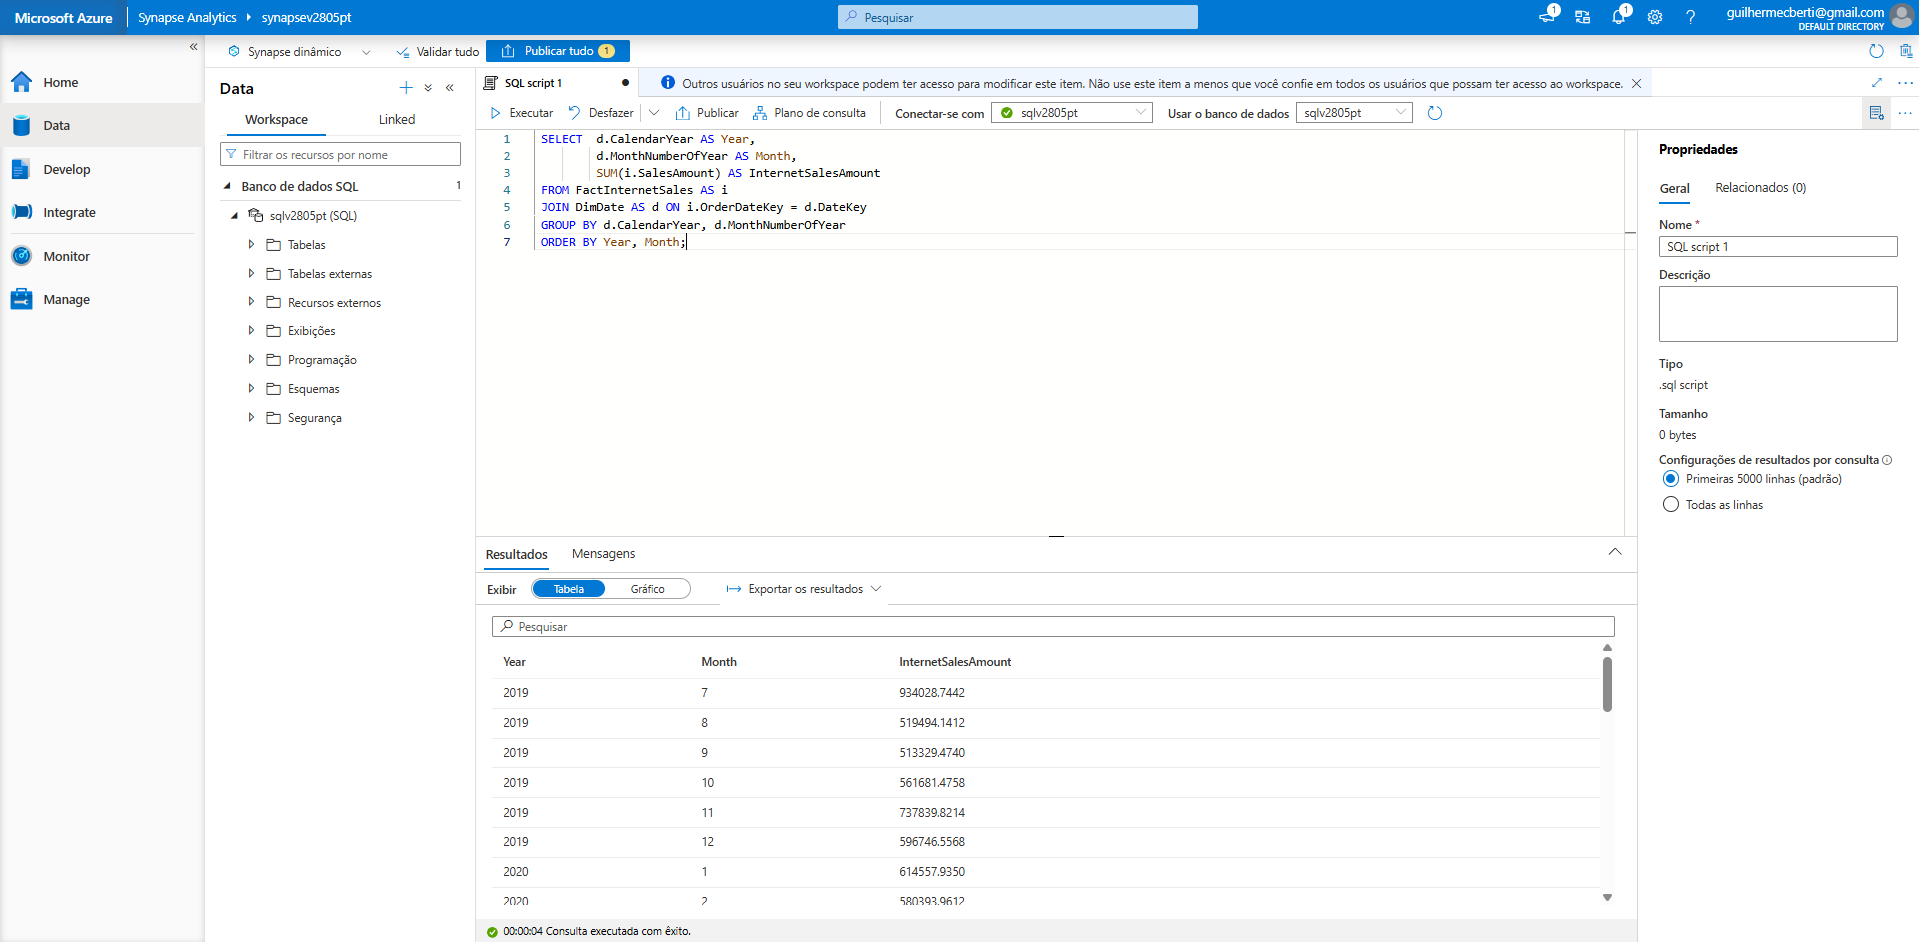

Modifique a consulta da seguinte maneira para remover o mês e adicionar uma segunda dimensão à agregação e, em seguida, execute-a para visualizar os resultados (que mostram os totais anuais de vendas na Internet para cada região):

In [ ]:
 SELECT  d.CalendarYear AS Year,
         g.EnglishCountryRegionName AS Region,
         SUM(i.SalesAmount) AS InternetSalesAmount
 FROM FactInternetSales AS i
 JOIN DimDate AS d ON i.OrderDateKey = d.DateKey
 JOIN DimCustomer AS c ON i.CustomerKey = c.CustomerKey
 JOIN DimGeography AS g ON c.GeographyKey = g.GeographyKey
 GROUP BY d.CalendarYear, g.EnglishCountryRegionName
 ORDER BY Year, Region;

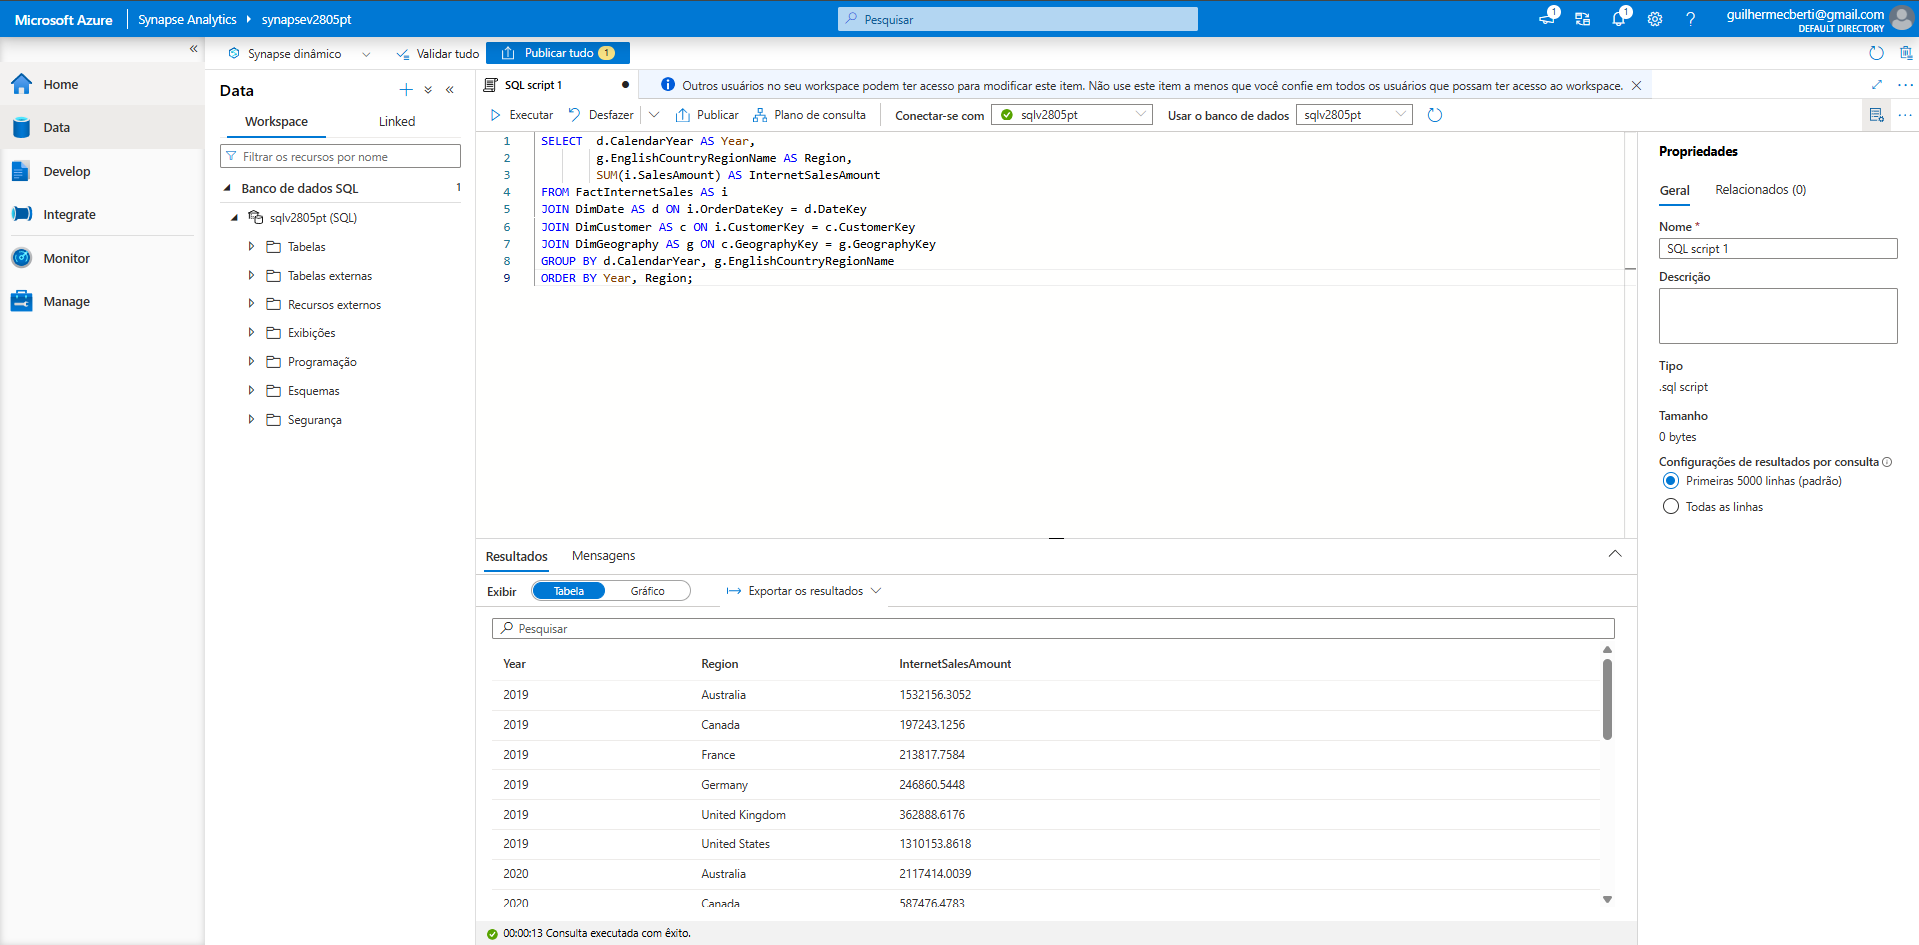

Observe que geografia é uma dimensão floco de neve relacionada à tabela de fatos de vendas pela internet por meio da dimensão cliente. Portanto, você precisa de duas junções na consulta para agregar as vendas pela internet por geografia.

Desta vez, a dimensão floco de neve para categoria de produto requer três junções para refletir o relacionamento hierárquico entre produtos, subcategorias e categorias:

In [ ]:
 SELECT  d.CalendarYear AS Year,
         pc.EnglishProductCategoryName AS ProductCategory,
         g.EnglishCountryRegionName AS Region,
         SUM(i.SalesAmount) AS InternetSalesAmount
 FROM FactInternetSales AS i
 JOIN DimDate AS d ON i.OrderDateKey = d.DateKey
 JOIN DimCustomer AS c ON i.CustomerKey = c.CustomerKey
 JOIN DimGeography AS g ON c.GeographyKey = g.GeographyKey
 JOIN DimProduct AS p ON i.ProductKey = p.ProductKey
 JOIN DimProductSubcategory AS ps ON p.ProductSubcategoryKey = ps.ProductSubcategoryKey
 JOIN DimProductCategory AS pc ON ps.ProductCategoryKey = pc.ProductCategoryKey
 GROUP BY d.CalendarYear, pc.EnglishProductCategoryName, g.EnglishCountryRegionName
 ORDER BY Year, ProductCategory, Region;

## Use funções de classificação

 SELECT  g.EnglishCountryRegionName AS Region,
         ROW_NUMBER() OVER(PARTITION BY g.EnglishCountryRegionName
                           ORDER BY i.SalesAmount ASC) AS RowNumber,
         i.SalesOrderNumber AS OrderNo,
         i.SalesOrderLineNumber AS LineItem,
         i.SalesAmount AS SalesAmount,
         SUM(i.SalesAmount) OVER(PARTITION BY g.EnglishCountryRegionName) AS RegionTotal,
         AVG(i.SalesAmount) OVER(PARTITION BY g.EnglishCountryRegionName) AS RegionAverage
 FROM FactInternetSales AS i
 JOIN DimDate AS d ON i.OrderDateKey = d.DateKey
 JOIN DimCustomer AS c ON i.CustomerKey = c.CustomerKey
 JOIN DimGeography AS g ON c.GeographyKey = g.GeographyKey
 WHERE d.CalendarYear = 2022
 ORDER BY Region;

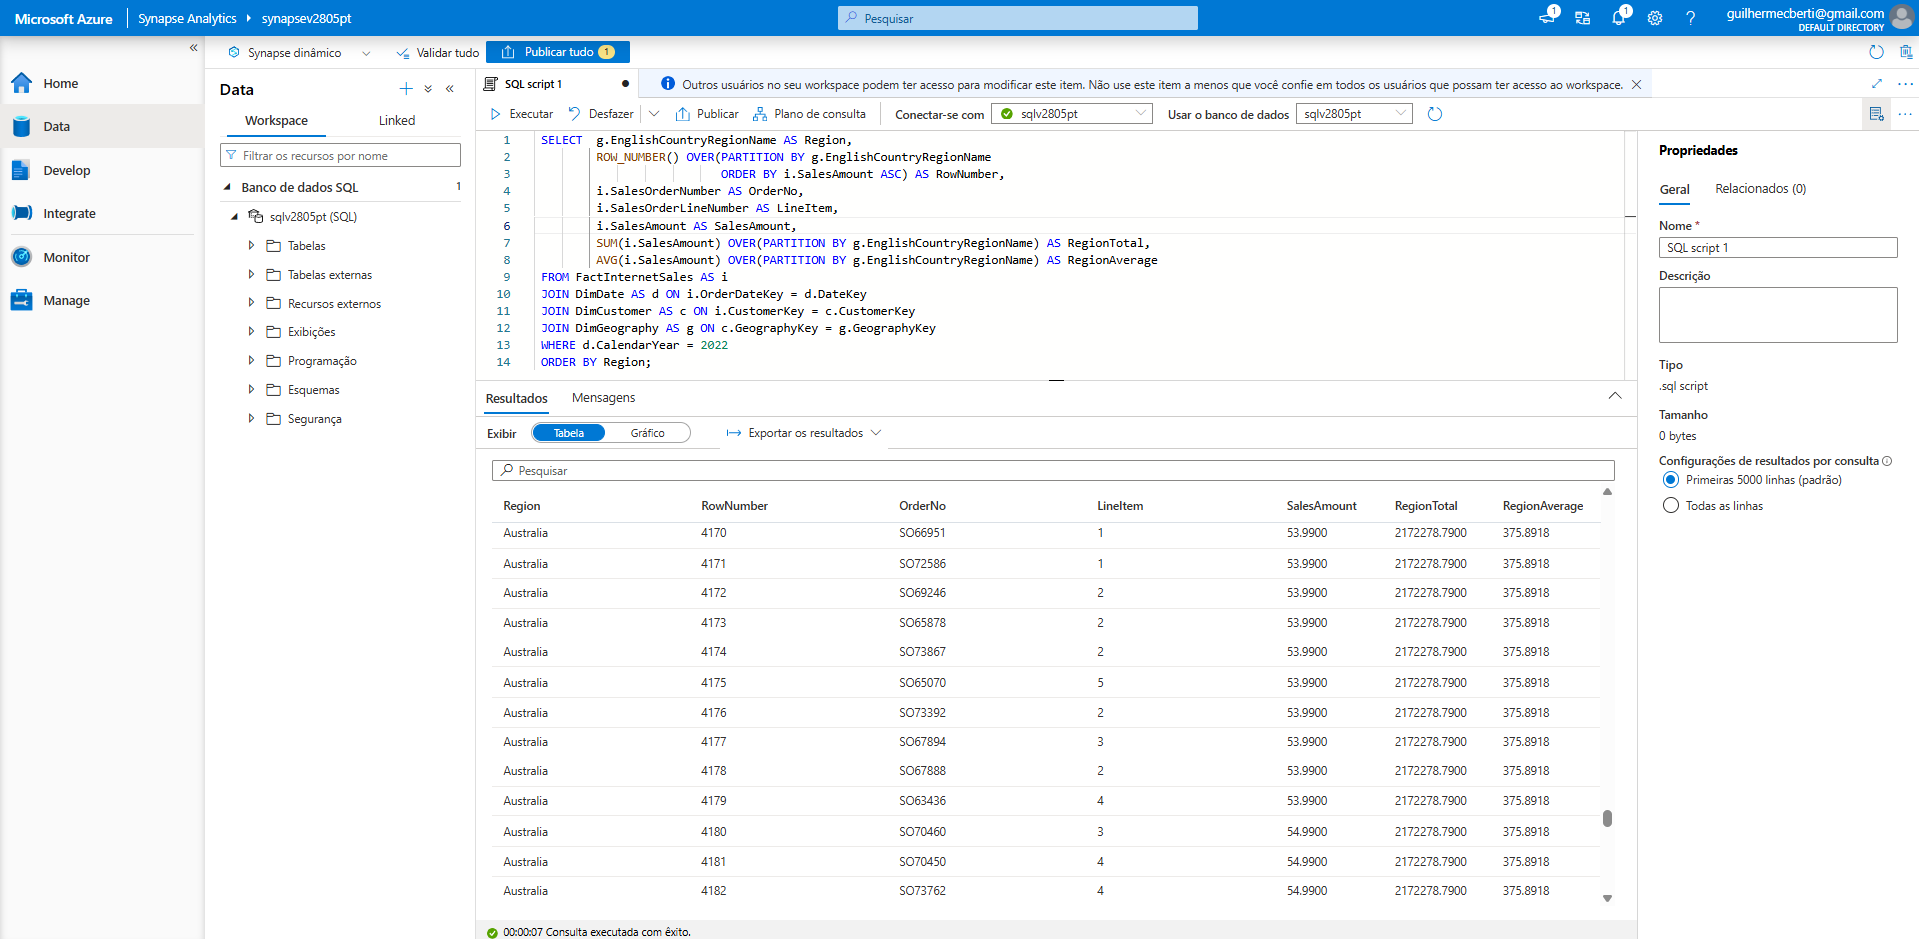

Observe os seguintes fatos sobre esses resultados:

Há uma linha para cada item de pedido de venda.

As linhas são organizadas em partições com base na geografia onde a venda foi realizada.

As linhas dentro de cada partição geográfica são numeradas em ordem de valor de venda (do menor para o maior).

Para cada linha, são incluídos o valor de venda do item, bem como o total regional e os valores médios de venda.